# LONG SHORT TERM MEMORY (LSTM)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf
import random

# Import Dataset

In [2]:
# Set the random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Import Dataset
 # EUR - VND
eur = pd.read_csv('EUR.csv')
 # GBP - VND
gbp = pd.read_csv("GBP.csv")
 # JPY - VND
jpy = pd.read_csv("JPY.csv")
# Convert
eur = eur['Sale'].replace({',':''}, regex=True).astype(float)
gbp = gbp['Sale'].replace({',':''}, regex=True).astype(float)
jpy = jpy['Sale'].replace({',':''}, regex=True).astype(float)

# Scaler model
scaler=MinMaxScaler(feature_range=(0,1))


# Function to standardize the data

In [3]:
def standardizate_data(train, test, pre_test, f3, f6, f9):
    # Train
    train = np.reshape(train, (-1,1))
    train1 = scaler.inverse_transform(train)
    # Test
    test = np.reshape(test, (-1,1))
    test1 = scaler.inverse_transform(test)
    # Test prediction
    pre_test = np.reshape(pre_test, (-1,1))
    pre_test1 = scaler.inverse_transform(pre_test)
    # Forecast 30
    f3 = np.reshape(f3, (-1,1))
    f3_tf= scaler.inverse_transform(f3)
    # Forecast 60
    f6 = np.reshape(f6, (-1,1))
    f6_tf= scaler.inverse_transform(f6)
    # Forecast 90
    f9 = np.reshape(f9, (-1,1))
    f9_tf= scaler.inverse_transform(f9)
    
    return train1, test1, pre_test1, f3_tf, f6_tf, f9_tf 


### Convert-data Function

In [4]:
# Convert train, test data into X_train, y_train, X_test, y_test
# Function to convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

# Function to convert data
def convert_data(train, test, time_step):
    # Reshape into X = t, t+1, t+2 ,..., t+99 and Y = t+100
    X_train, y_train = create_dataset(train, time_step)
    X_test, y_test = create_dataset(test, time_step)
    # Reshape input to be [samples, time steps, features] which is required for LSTM
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  # => 3D
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    return X_train, y_train, X_test, y_test



# Function to forecast next 30, 60, 90 days data

In [5]:
def forecast_days(model, test):
    x_input = test[len(test)-100:].reshape(1, -1)

    temp_input = list(x_input)
    temp_input = temp_input[0].tolist()

    forecast30 = []
    forecast60 = []
    forecast90 = []
    n_steps = 100
    i = 0
    while(i <= 90):
        if(len(temp_input) > 100):
            x_input = np.array(temp_input[1:])
            print("{} day input {}".format(i, x_input))
            x_input = x_input.reshape(1, -1)
            x_input = x_input.reshape((1, n_steps, 1))  # 3D
            yhat = model.predict(x_input, verbose=0)
            print("{} day output {}".format(i, yhat))
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            if i <= 30:
                forecast30.extend(yhat.tolist())
            elif i <= 60:
                forecast60.extend(yhat.tolist())
            else:
                forecast90.extend(yhat.tolist())
            i = i + 1
        else:
            x_input = x_input.reshape((1, n_steps, 1))
            yhat = model.predict(x_input, verbose=0)
            print(yhat[0])
            temp_input.extend(yhat[0].tolist())
            print(len(temp_input))
            forecast30.extend(yhat.tolist())
            i = i + 1
    return forecast30, forecast60, forecast90

# Function to visualize the model

In [6]:
def visualize_LSTM(model, train, test, pre_test, f3, f6, f9):
    # set index
    # set train, test index
    index = pd.date_range(start='3/1/2019', periods=len(train) + len(test), freq='d')
    # set forecast index
    forecast_index = pd.date_range(start='6/1/2024', periods=91, freq='d')
    
    # Visualize
    plt.figure(figsize=(12, 6))
    plt.plot(index[:len(train)], scaler.inverse_transform(train))
    plt.plot(index[len(train):], scaler.inverse_transform(test))
    plt.plot(index[len(train)+100:], scaler.inverse_transform(pre_test))
    plt.plot(forecast_index[:31], scaler.inverse_transform(f3))
    plt.plot(forecast_index[31:61], scaler.inverse_transform(f6))
    plt.plot(forecast_index[61:], scaler.inverse_transform(f9))

    # Highlight the transition point from test data to predictions
    transition_point = pd.Timestamp('2024-06-01')
    plt.axvline(x=transition_point, color='r', linestyle='--', label='01/06/2024')

    plt.title('LSTM Time Series Forecast')
    plt.xlabel('Date')
    plt.ylabel('Exchange Rate (VND)')
    plt.legend(['Train', 'Test', 'TestPred', 'Forecast 30 days next', 'Forecast 60 days next', 'Forecast 90 days next', '01/06/2024'])
    plt.show()


# Function to evaluate the model

In [7]:
def evaluate(forecast, actual):
    forecast = np.array(forecast)
    actual = np.array(actual)
    mape = np.mean(np.abs(forecast - actual) / np.abs(actual)) * 100  # MAPE
    mae = np.mean(np.abs(forecast - actual))  # MAE
    rmse = np.mean((forecast - actual) ** 2) ** .5  # RMSE

    print('RMSE =', rmse)
    print('MAPE(%) =', mape)
    print('MAE =', mae)

### Function to implement LSTM

In [8]:
def implement_LSTM(train, test):
    time_step = 100
    # Convert Train, Test data
    X_train, y_train, X_test, y_test = convert_data(train, test, time_step)

    # Define LSTM model
    model = Sequential()
    model.add(LSTM(50, input_shape=(time_step, 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Fit model
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

    # Predict Test data
    pre_test = model.predict(X_test)

    # Forecast next 30, 60, 90 days data
    forecast30, forecast60, forecast90 = forecast_days(model, test)

    # Visualize model
    visualize_LSTM(model, train, test, pre_test, forecast30, forecast60, forecast90)

    # Standardize
    train, test, pre_test, forecast30, forecast60, forecast90 = standardizate_data(train, test, pre_test, forecast30, forecast60, forecast90)

    # Measure accuracy
    evaluate(pre_test, test[100:])



# EUR_VND

In [9]:
# Scale data
eur_sc = scaler.fit_transform(np.array(eur).reshape(-1, 1))
# Split train, test data
## case 1. 7:3
train_eur_1_sc = eur_sc[:int(0.7 * len(eur))]
test_eur_1_sc = eur_sc[int(0.7 * len(eur)):]
## case 2. 8:2
train_eur_2_sc = eur_sc[:int(0.8 * len(eur))]
test_eur_2_sc = eur_sc[int(0.8 * len(eur)):]
## case 3. 9:1
train_eur_3_sc = eur_sc[:int(0.9 * len(eur))]
test_eur_3_sc = eur_sc[int(0.9 * len(eur)):]



EUR_7:3

c:\Users\Windows\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.2066 - val_loss: 0.0055
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0066 - val_loss: 0.0014
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0036 - val_loss: 0.0017
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0026 - val_loss: 0.0011
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0020 - val_loss: 9.9064e-04
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0017 - val_loss: 9.7498e-04
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0016 - val_loss: 9.6502e-04
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0015 - val_loss: 9.4359e-04
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0015 - val_loss: 9.1929e-04
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0015 - val_loss: 9.0077e-04
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0015 - val_loss: 8.8820e-04
Epoch 12/100
20/20 ━━━━━

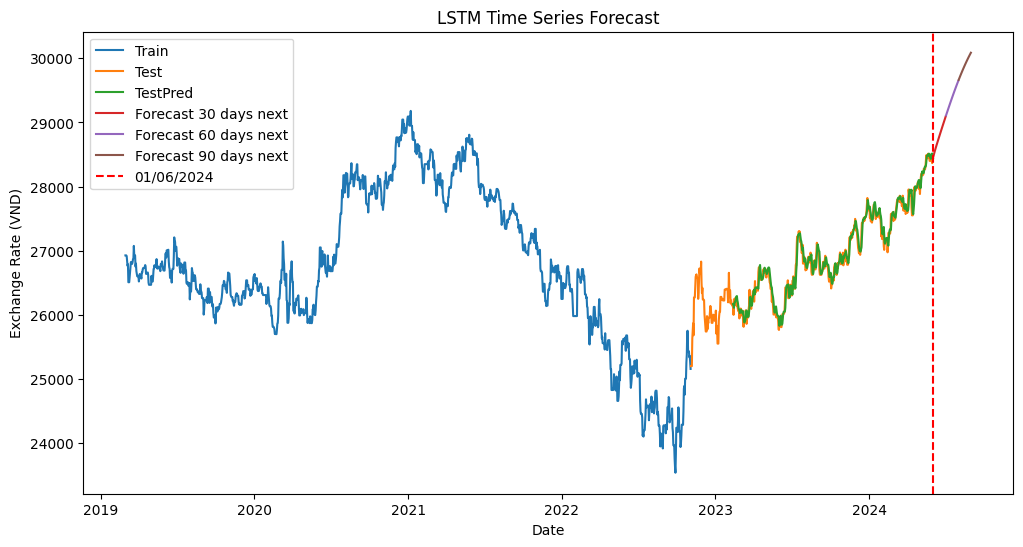

RMSE = 101.1077551145684
MAPE(%) = 0.2873877908720007
MAE = 77.32474396008419


In [10]:
implement_LSTM(train_eur_1_sc, test_eur_1_sc)

EUR_8:2

Epoch 1/100


c:\Users\Windows\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.1809 - val_loss: 0.0019
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0065 - val_loss: 0.0012
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0036 - val_loss: 0.0011
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0024 - val_loss: 0.0010
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0018 - val_loss: 9.3977e-04
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0016 - val_loss: 9.1666e-04
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0016 - val_loss: 8.9965e-04
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0016 - val_loss: 8.8560e-04
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0015 - val_loss: 8.7510e-04
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0015 - val_loss: 8.6310e-04
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0015 - val_loss: 8.5007e-04
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━

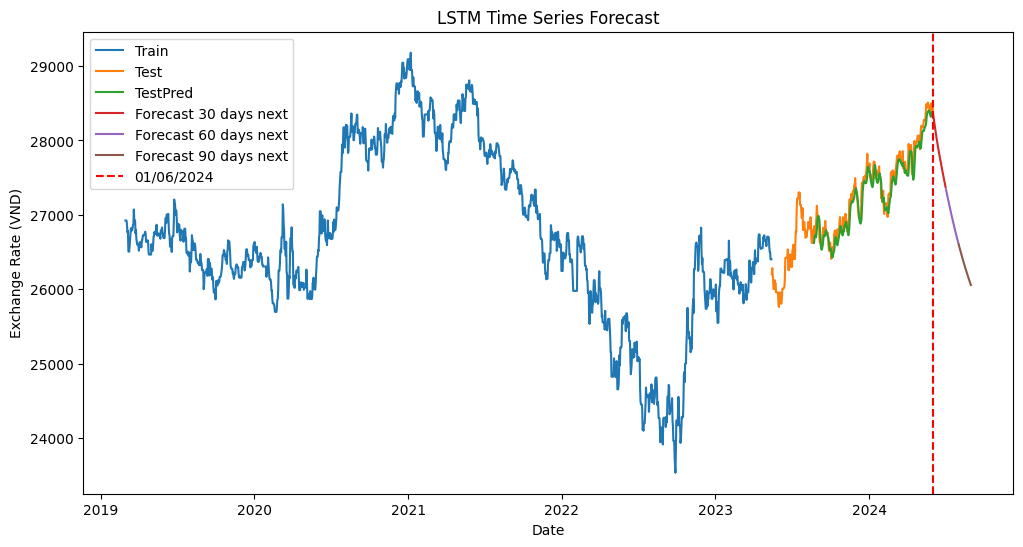

RMSE = 127.05364483134724
MAPE(%) = 0.36740858215889705
MAE = 100.77976452464792


In [11]:
implement_LSTM(train_eur_2_sc, test_eur_2_sc)

EUR_9:1

Epoch 1/100


c:\Users\Windows\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1026 - val_loss: 0.0164
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0049 - val_loss: 0.0030
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0021 - val_loss: 9.1729e-04
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0015 - val_loss: 5.0312e-04
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0013 - val_loss: 5.3790e-04
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0013 - val_loss: 5.1934e-04
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0012 - val_loss: 5.0978e-04
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0012 - val_loss: 5.0363e-04
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0012 - val_loss: 4.9734e-04
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0012 - val_loss: 4.9022e-04
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0012 - val_loss: 4.8328e-04
Epoch 12/100
26/26 ━━━━━━━━━

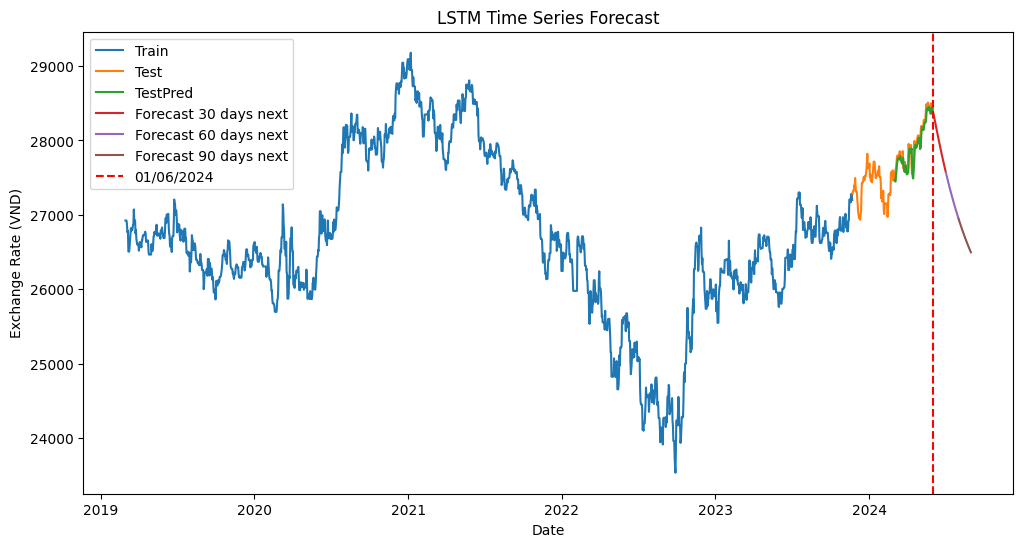

RMSE = 95.39725090753335
MAPE(%) = 0.25987905671270617
MAE = 72.6172299592391


In [12]:
implement_LSTM(train_eur_3_sc, test_eur_3_sc)

# GBP_VND

In [13]:
# Scale data
gbp_sc = scaler.fit_transform(np.array(gbp).reshape(-1, 1))
# Split train, test data
## case 1. 7:3
train_gbp_1_sc = gbp_sc[:int(0.7 * len(gbp))]
test_gbp_1_sc = gbp_sc[int(0.7 * len(gbp)):]
## case 2. 8:2
train_gbp_2_sc = gbp_sc[:int(0.8 * len(gbp))]
test_gbp_2_sc = gbp_sc[int(0.8 * len(gbp)):]
## case 3. 9:1
train_gbp_3_sc = gbp_sc[:int(0.9 * len(gbp))]
test_gbp_3_sc = gbp_sc[int(0.9 * len(gbp)):]



GBP_7:3

Epoch 1/100


c:\Users\Windows\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.3123 - val_loss: 0.0163
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0110 - val_loss: 0.0034
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0043 - val_loss: 0.0024
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0036 - val_loss: 0.0014
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0030 - val_loss: 0.0012
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0026 - val_loss: 0.0011
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0023 - val_loss: 9.4407e-04
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0021 - val_loss: 8.8964e-04
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0021 - val_loss: 8.7125e-04
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0020 - val_loss: 8.7043e-04
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0020 - val_loss: 8.7587e-04
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 2

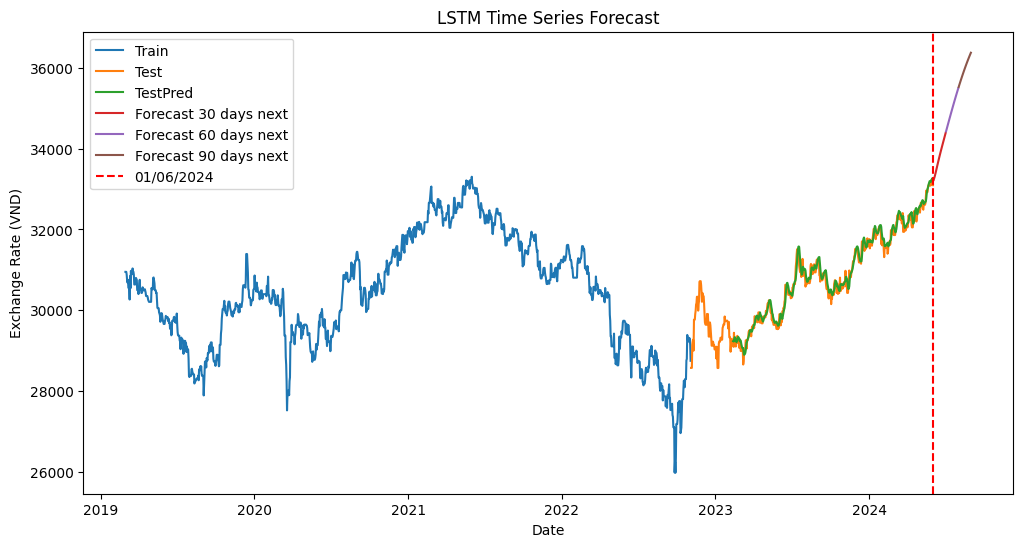

RMSE = 147.36178663516148
MAPE(%) = 0.37423456565201507
MAE = 115.56824858849797


In [14]:
implement_LSTM(train_gbp_1_sc, test_gbp_1_sc)

GBP_8:2

Epoch 1/100


c:\Users\Windows\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.2166 - val_loss: 0.0013
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0056 - val_loss: 0.0014
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0037 - val_loss: 0.0026
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0019 - val_loss: 9.6426e-04
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0018 - val_loss: 8.5838e-04
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0017 - val_loss: 7.9900e-04
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0017 - val_loss: 7.6087e-04
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0017 - val_loss: 7.3714e-04
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0016 - val_loss: 7.1962e-04
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 

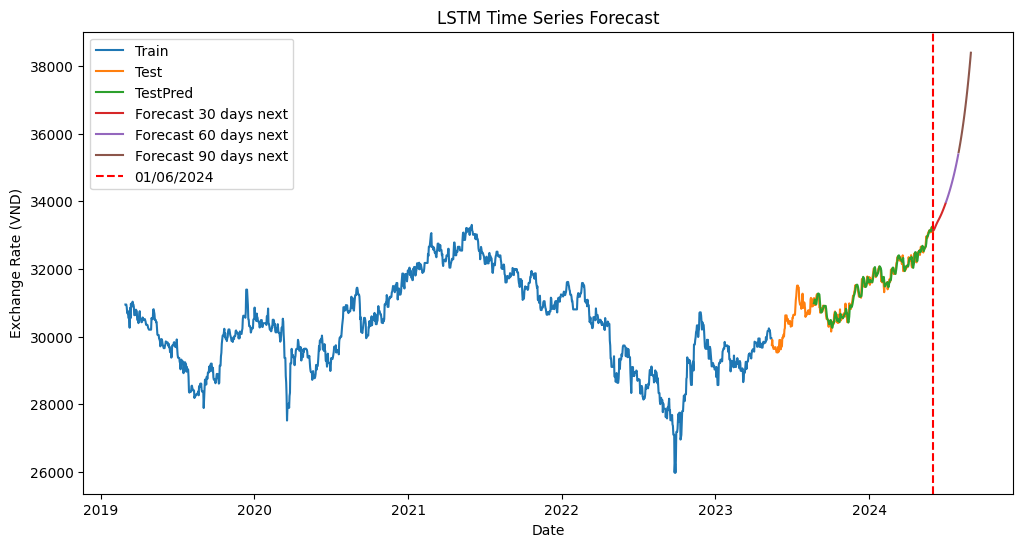

RMSE = 122.03047850348916
MAPE(%) = 0.2930292061240876
MAE = 92.34846088248253


In [15]:
implement_LSTM(train_gbp_2_sc, test_gbp_2_sc)

GBP_9:1

Epoch 1/100


c:\Users\Windows\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.2185 - val_loss: 0.0231
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0068 - val_loss: 0.0036
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0021 - val_loss: 9.6775e-04
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0019 - val_loss: 7.4225e-04
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0018 - val_loss: 6.7747e-04
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0018 - val_loss: 6.2917e-04
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0017 - val_loss: 6.1316e-04
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0017 - val_loss: 6.0924e-04
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0017 - val_loss: 6.1140e-04
Epoch 12/100
26/26 ━━━━━━━━━━━━━━━━━

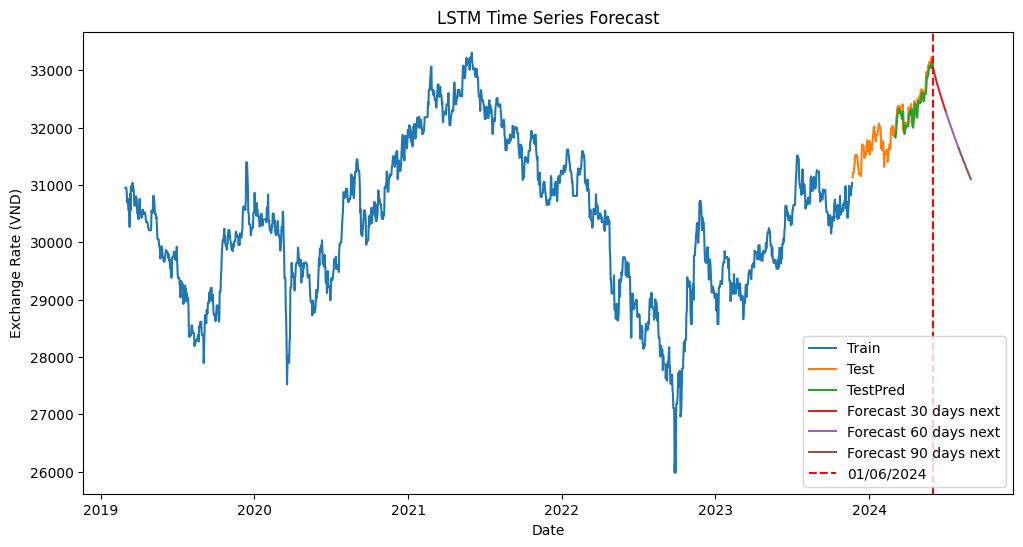

RMSE = 121.92414415583234
MAPE(%) = 0.29051066204016734
MAE = 94.22556470788086


In [16]:
implement_LSTM(train_gbp_3_sc, test_gbp_3_sc)

# JPY_VND

In [17]:
# Scale data
jpy_sc = scaler.fit_transform(np.array(jpy).reshape(-1, 1))
# Split train, test data
## case 1. 7:3
train_jpy_1_sc = jpy_sc[:int(0.7 * len(jpy))]
test_jpy_1_sc = jpy_sc[int(0.7 * len(jpy)):]
## case 2. 8:2
train_jpy_2_sc = jpy_sc[:int(0.8 * len(jpy))]
test_jpy_2_sc = jpy_sc[int(0.8 * len(jpy)):]
## case 3. 9:1
train_jpy_3_sc = jpy_sc[:int(0.9 * len(jpy))]
test_jpy_3_sc = jpy_sc[int(0.9 * len(jpy)):]



JPY_7:3

Epoch 1/100


c:\Users\Windows\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.3467 - val_loss: 0.0198
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0078 - val_loss: 0.0151
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0038 - val_loss: 0.0101
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0028 - val_loss: 0.0079
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0020 - val_loss: 0.0050
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0015 - val_loss: 0.0031
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 9.7575e-04 - val_loss: 8.8948e-04
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 9.3350e-04 - val_loss: 7.3020e-04
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 9.1351e-04 - val_loss: 6.6005e-04
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 

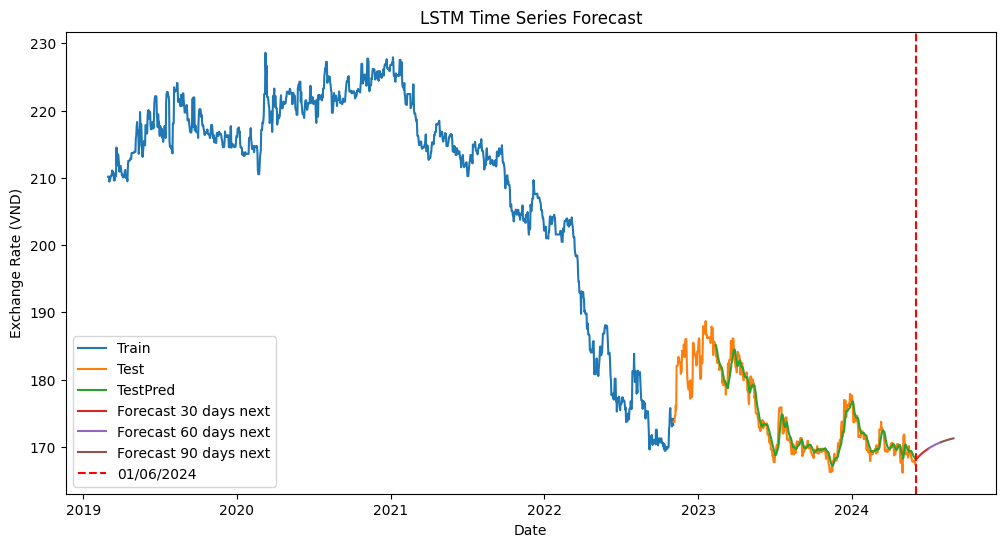

RMSE = 1.2665094188722623
MAPE(%) = 0.5517100004616604
MAE = 0.957435793836578


In [18]:
implement_LSTM(train_jpy_1_sc, test_jpy_1_sc)

JPY_8:2

Epoch 1/100


c:\Users\Windows\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1741 - val_loss: 0.0114
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0061 - val_loss: 0.0105
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0029 - val_loss: 0.0047
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0010 - val_loss: 9.0781e-04
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 8.5994e-04 - val_loss: 5.3754e-04
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 8.1933e-04 - val_loss: 4.3707e-04
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 8.1343e-04 - val_loss: 4.1250e-04
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 8.1102e-04 - val_loss: 4.0773e-04
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 8.0790e-04 - val_loss: 4.0784e-04
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 8.0441e-04 - val_loss: 4.0857e-04
Epoch 12/100

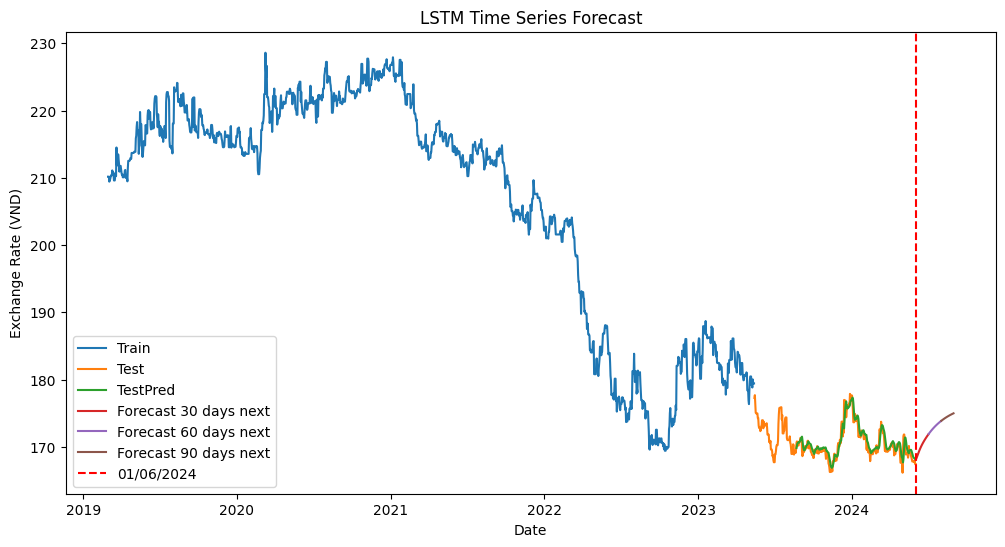

RMSE = 0.9897247144560233
MAPE(%) = 0.42998112372458713
MAE = 0.7332794167961882


In [19]:
implement_LSTM(train_jpy_2_sc, test_jpy_2_sc)

JPY_9:1

Epoch 1/100


c:\Users\Windows\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.2183 - val_loss: 0.0097
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0083 - val_loss: 0.0057
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0012 - val_loss: 5.7470e-04
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0011 - val_loss: 5.0062e-04
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0011 - val_loss: 5.0810e-04
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0011 - val_loss: 5.1768e-04
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0010 - val_loss: 5.2226e-04
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0010 - val_loss: 5.2575e-04
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0010 - val_loss: 5.2917e-04
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0010 - val_loss: 5.3211e-04
Epoch 12/100
26/26 ━━━━━━━━━━━━━

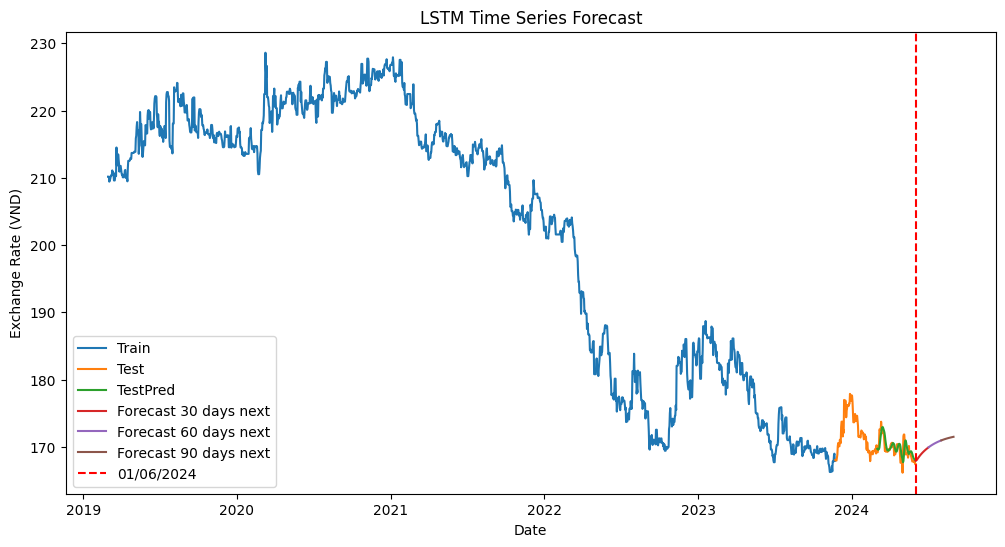

RMSE = 1.1149653980859306
MAPE(%) = 0.4939803122637538
MAE = 0.8389706686268682


In [20]:
implement_LSTM(train_jpy_3_sc, test_jpy_3_sc)